<a href="https://colab.research.google.com/github/SaswatoB/Data-Science-Engineering-Methods/blob/main/Feature%20Selection%20/%20ML_Data_Cleaning_and_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # **ML Data Cleaning and Feature Selection**






In [117]:
# Import libraries
# Use pip install or conda install if missing a library
import random, os, sys
from datetime import datetime
import pandas as pd
import csv
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

**Import** **Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving riceClassification.csv to riceClassification.csv


In [ ]:
import io
df = pd.read_csv(io.StringIO(uploaded['riceClassification.csv'].decode('utf-8')))

**Initial view of the data**

In [ ]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  int64  
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  int64  
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  Class            18185 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.5 MB


**Q. What are the data types?**



> We can see from the above cells that our dataset has 11 numeric variables and 1 categorical varibale (Class) which also is the dependent variable.



Checking for missing values

In [ ]:
df.isnull().sum()

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

**Q. Are there missing values?**


> As seen in the above cell, no missing values are present.
  Let us visualize this with a heatmap, just to be sure.



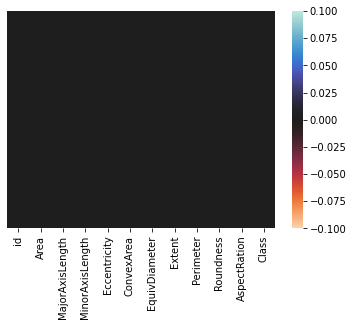

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False,cmap='icefire_r')

Let us drop unrequired columns and split the predictor varibles from the label

In [ ]:
df.drop('id',axis=1,inplace = True) #dropping ID

X = df.iloc[:,:-1]

y = df.iloc[:,-1]

Let us split the dataset into training and testing set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99 )

**Let us now visualize the distribution of our predictor variables**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10b1b7aa50>,
      dtype=object)

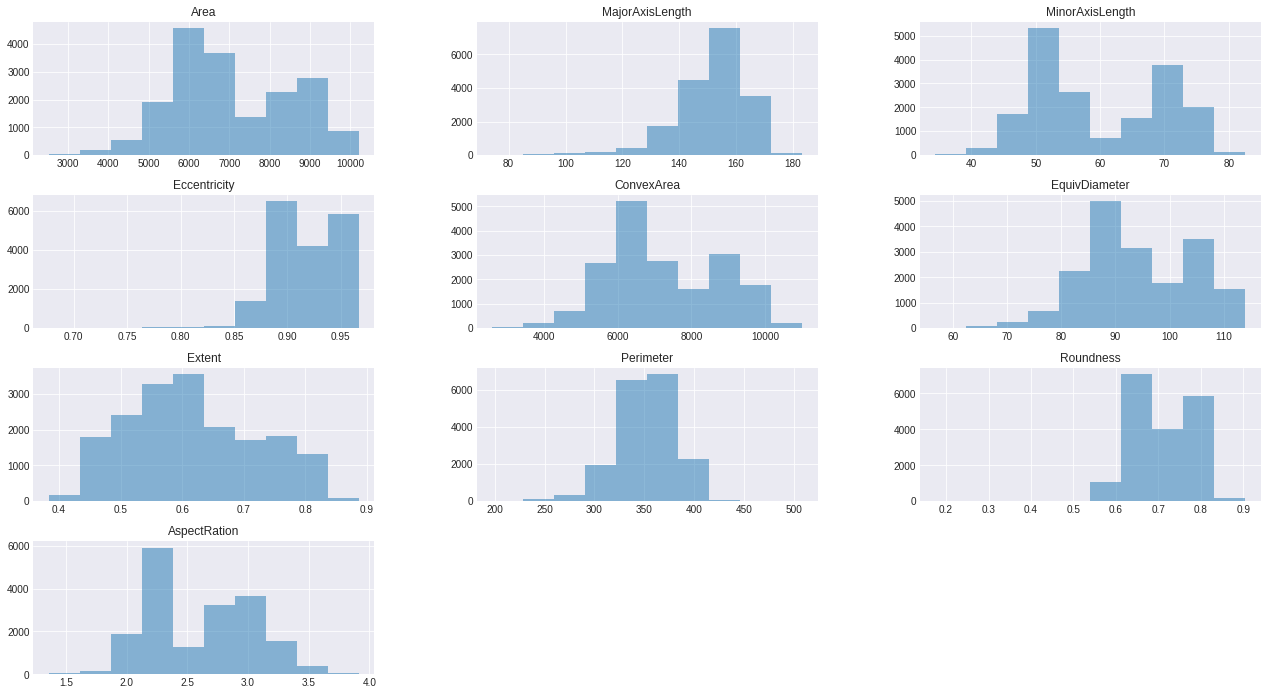

In [ ]:
plt.style.use('seaborn-dark')
X.hist(alpha=0.5, figsize=(22, 12))

**Q. What are the likely distributions of the numeric variables?**


> The data in Area, Convex Area, EquivDiameter, Extent, Perimeter columns seem to be normally distributed.
The MinorAxisLength column has a bimodal distribution as the data is concentrated around 2 buckets.
MajorAxisLength is seen to be Right-skewed. While Roundness and Eccentricity is somewhat uniformly distributed.






**Q. Which independent variables are useful to predict a target (dependent variable)?**

> To answer this question, we will use 3 different approaches.

> **1.** Firstly, we will check the correlation between the predictor and the target variable along with it's p-value.

In [ ]:
corr_df = pd.DataFrame(columns=['r','p-value'])

for i in X:
    r, p =stats.pointbiserialr(y,X[i])
    corr_df.loc[i] = [round(r,3),p]

corr_df.sort_values(by='p-value', ascending= False)


,r,p-value
MajorAxisLength,-0.148,2.911094e-89
Area,-0.817,0.000000e+00
MinorAxisLength,-0.918,0.000000e+00
Eccentricity,0.789,0.000000e+00
ConvexArea,-0.814,0.000000e+00
EquivDiameter,-0.809,0.000000e+00
Extent,-0.303,0.000000e+00
Perimeter,-0.533,0.000000e+00
Roundness,-0.832,0.000000e+00
AspectRation,0.833,0.000000e+00


It can be seen that only the MajorAxisLength parameter has a significant p-value, although it's correlation coefficient with the label is very low and negative. This means only MajorAxisLength is a useful predictor and is inversely correlated with the target.

In the above illustration, we used point biserial rank. This is used when we are finding the correlation between a binary categorical variable and a continuous variable. More about this can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html))

> **2.** Now, we move on to the second method to find predictor importance known as **Variance Inflation Factor** or **VIF**.  
It is calculated by the inverse of **(1 - R^2)**.
The higher the **R^2** the higher the VIF and multicollinearity.

Firstly, we scale all the features using a Standard scaler.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)
X_sc =pd.DataFrame(X_sc,index= X.index, columns= X.columns)
X_s = X_sc # backup used later
X_sc.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
0,-1.703630,-4.803744,0.417927,-6.393938,-1.696989,-1.830049,0.391654,-2.661778,0.839588,-2.663800
1,-2.838478,-6.220789,-0.835611,-6.209583,-2.803539,-3.398143,0.923070,-4.857318,1.837215,-2.635418
2,-2.718519,-6.091404,-0.771700,-6.024520,-2.725641,-3.213879,1.365122,-4.799860,2.383587,-2.605950
3,-2.701479,-6.031573,-0.783130,-5.781578,-2.708996,-3.188141,1.598635,-4.777995,2.409877,-2.565690
4,-2.278893,-5.377799,-0.341288,-5.433479,-2.279559,-2.580390,1.463045,-4.111042,2.477331,-2.504645


**Apply VIF**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X_sc.columns
    vif["VIF"] = [variance_inflation_factor(X_sc.values, i) for i in range(X_sc.shape[1])]
    vif = vif.sort_values(by = 'VIF', ascending=False)
    return(vif)
calc_vif(X_sc)

,variables,VIF
5,EquivDiameter,2844.995049
0,Area,2347.459870
4,ConvexArea,1813.854237
2,MinorAxisLength,1296.490608
7,Perimeter,346.462939
1,MajorAxisLength,318.714833
8,Roundness,157.668241
9,AspectRation,118.998499
3,Eccentricity,51.971818
6,Extent,1.157557


It is observed that there is high multicollinearity in many features.
Ideally, VIF value should be < 10. 
The features with high VIF are not useful for prediction.

Thus, we create a function to drop features with VIF > 10. 

Note: once a feature is dropped, VIF changes for the remaining features as well.

In [ ]:
def drop_large_vif(a):
    calc_vif(a)
    for i in range(len(a.columns)-1):
        col = calc_vif(a).iloc[0,0]
        val = calc_vif(a).iloc[0,1]
        if val > 10:
            a.drop(col,axis=1,inplace=True)
    return calc_vif(a)
    
drop_large_vif(X_sc)

,variables,VIF
1,Eccentricity,5.876661
3,Roundness,5.753991
2,Extent,1.155467
0,MajorAxisLength,1.123905


The above 4 features can be considered useful for prediction.

> **3.**  The final technique to be discussed is Mutual Information **MI.** 

>MI measures the dependency between the two variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

MinorAxisLength    0.644319
AspectRation       0.572220
Eccentricity       0.572187
Roundness          0.531317
Area               0.503299
EquivDiameter      0.502564
ConvexArea         0.495244
Perimeter          0.220000
Extent             0.188247
MajorAxisLength    0.013270
dtype: float64

The above result show the important features in desceding order.
Let's plot the result.

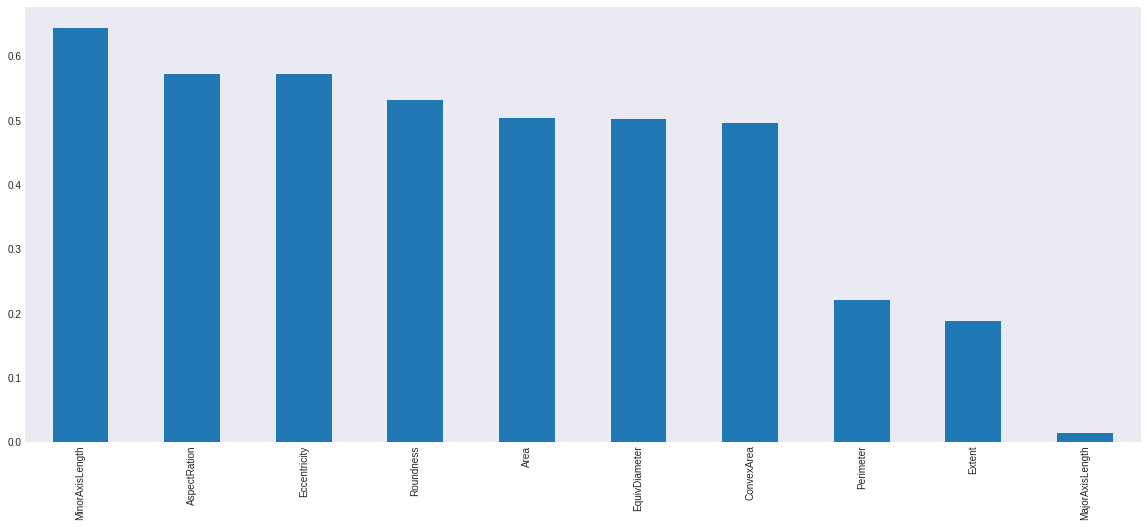

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

**Q. Do the training and test sets have the same data?**

> No. They are from the same distribution but not equal to each other.

**Q. Are the predictor variables independent of all the other predictor variables?**



> To find this, we need to find if there is any correlation between the features. 

> Let us plot a correlation heatmap to test this.



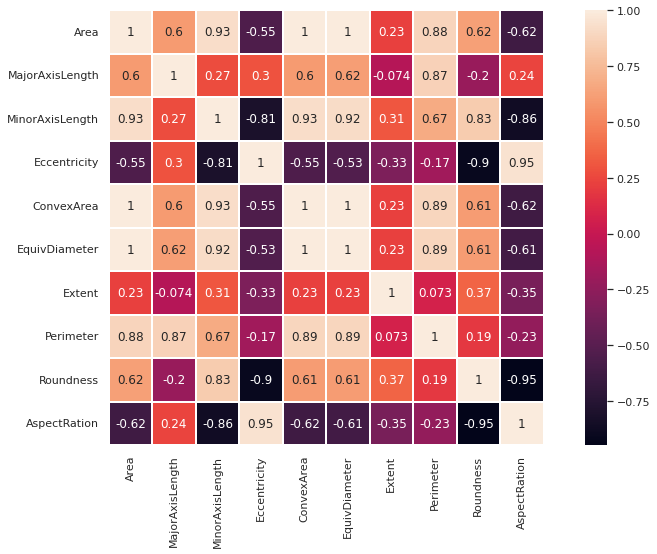

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X_s.corr(), linewidths=1, annot = True, square =True , )



> The above figure shows that there is multicollinearity present. Thus some predictor variables are dependent on others.

We can learn more about multicollinearity from [here](https://towardsdatascience.com/how-to-identify-the-right-independent-variables-for-machine-learning-supervised-algorithms-439986562d32)



**Q. Which predictor variables are the most important?**



> For this question, we will use the **SelectKBest** package to find the top 4 important features.

> It uses mutual information (MI) that we have already calculated above to select the K best features.



In [ ]:
from sklearn.feature_selection import SelectKBest

sel_four_cols = SelectKBest(mutual_info_classif, k=4)
sel_four_cols.fit(X, y)
X.columns[sel_four_cols.get_support()]

Index(['MinorAxisLength', 'Eccentricity', 'Roundness', 'AspectRation'], dtype='object')

We can change the number of best features by changing k.

**Q. Do the ranges of the predictor variables make sense?**



> To answer this, let us plot the ranges of all the predictor variables using boxplot graph.



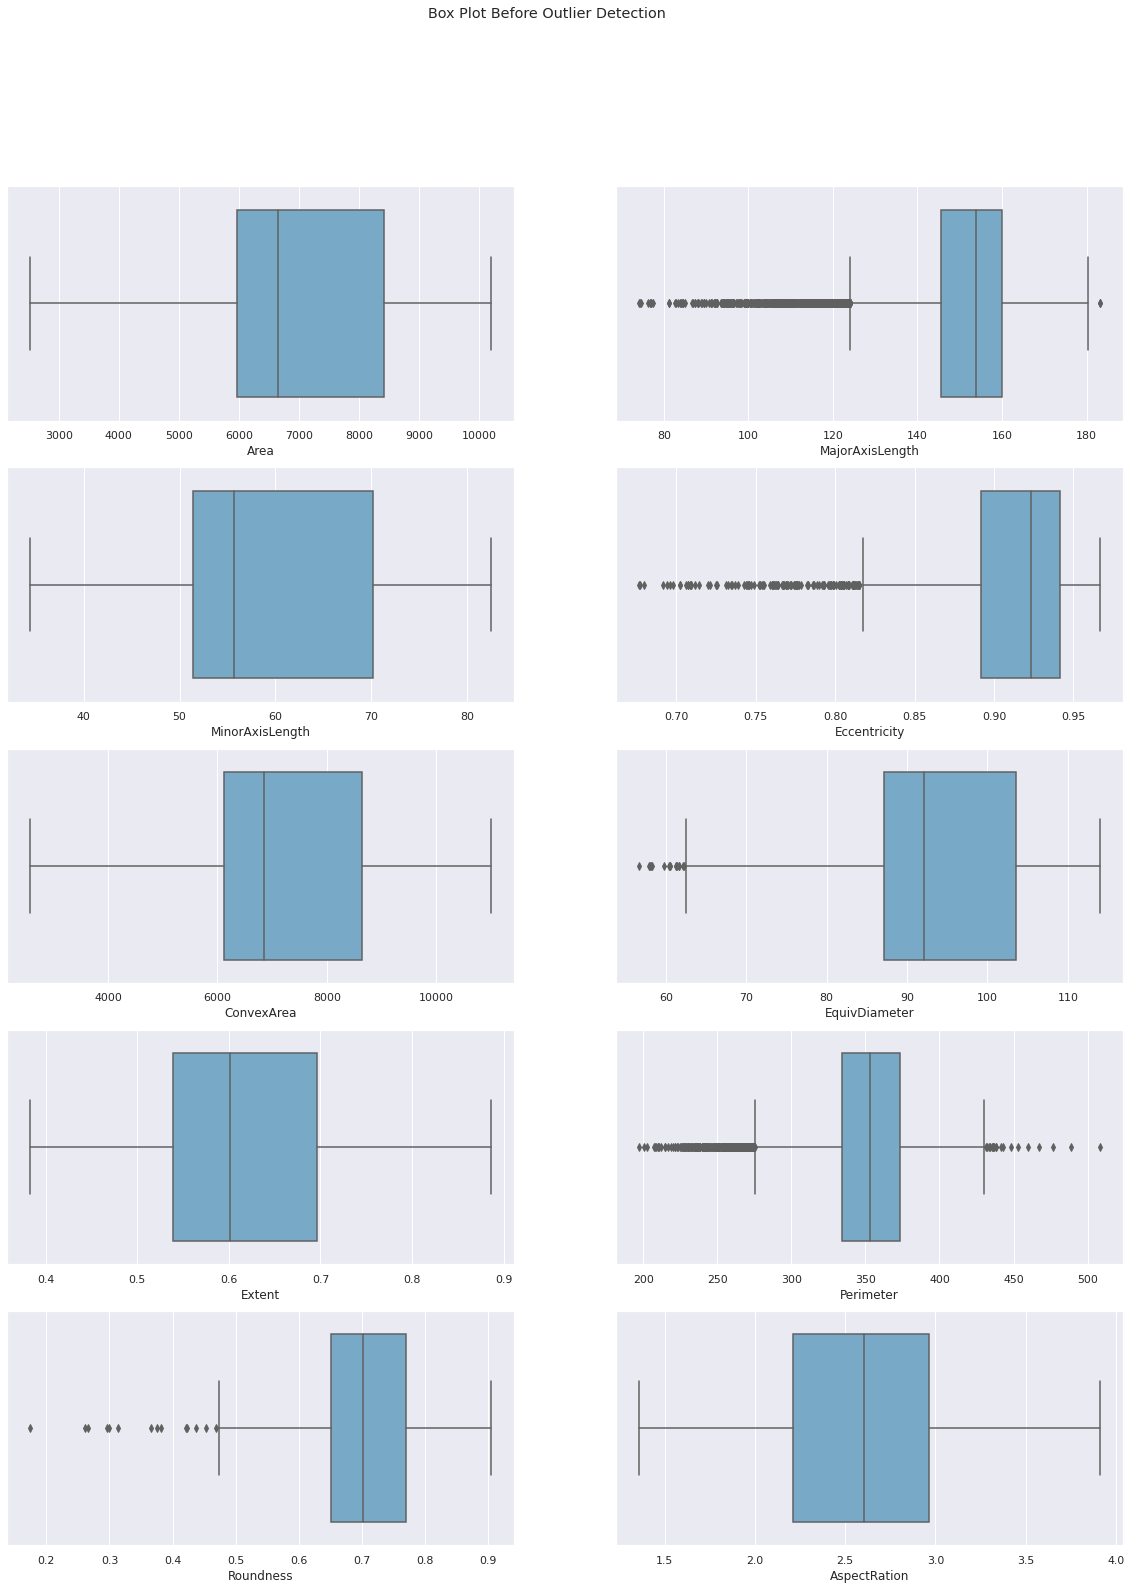

In [ ]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(5,2, figsize=(20,25))
fig.suptitle('Box Plot Before Outlier Detection')
k = 0
for i in range(0,5):
    for j in range(0,2):
        sns.boxplot(ax=axes[i,j], data=df, x=X.columns[k], palette="Blues")
        k=k+1

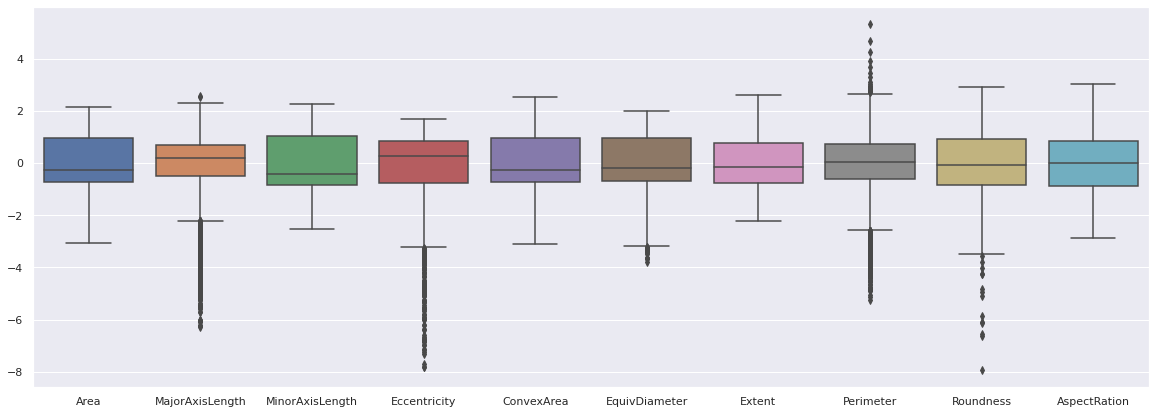

In [ ]:
plt.figure(figsize=(20,7))
sns.boxplot(data=X_s)

The Eccentricity, MajorAxisLength, Perimeter and Roundness have large number of outliers.

Most of the variables have similar IQR which might explain the high multicollinearity in the data.

**Q. What are the distributions of the predictor variables?**



> Let us visualize this through QQplots instead of histograms which was illustrated earlier.



<Figure size 576x360 with 0 Axes>

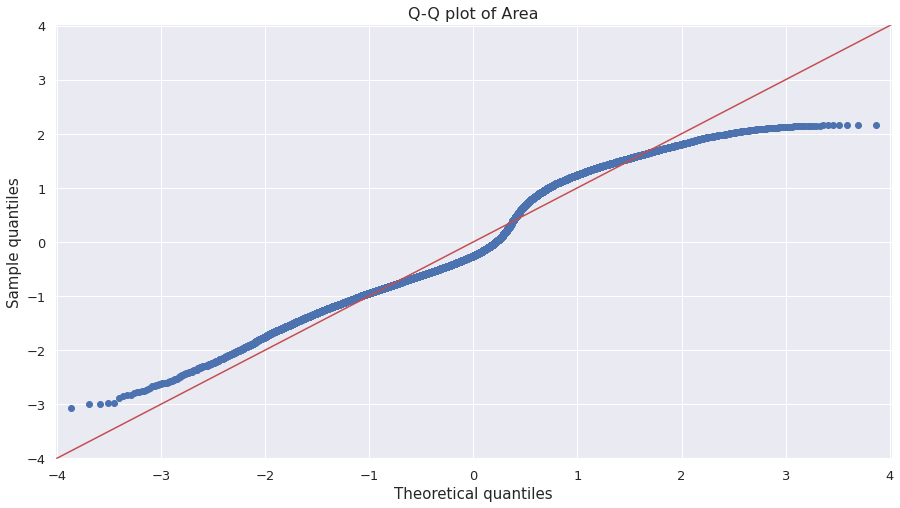

<Figure size 576x360 with 0 Axes>

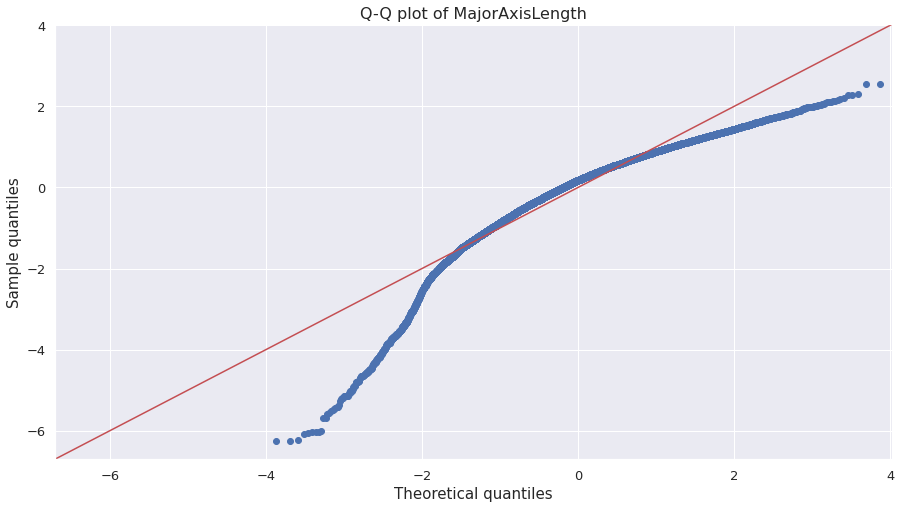

<Figure size 576x360 with 0 Axes>

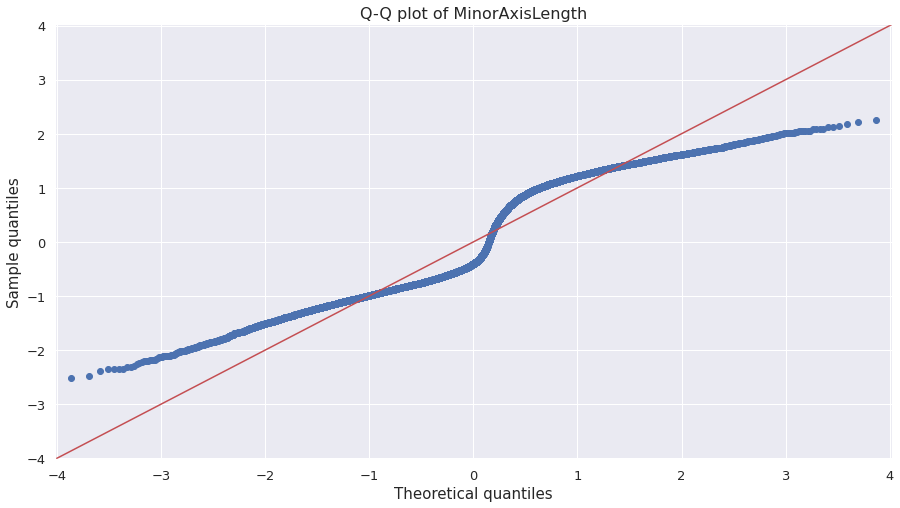

<Figure size 576x360 with 0 Axes>

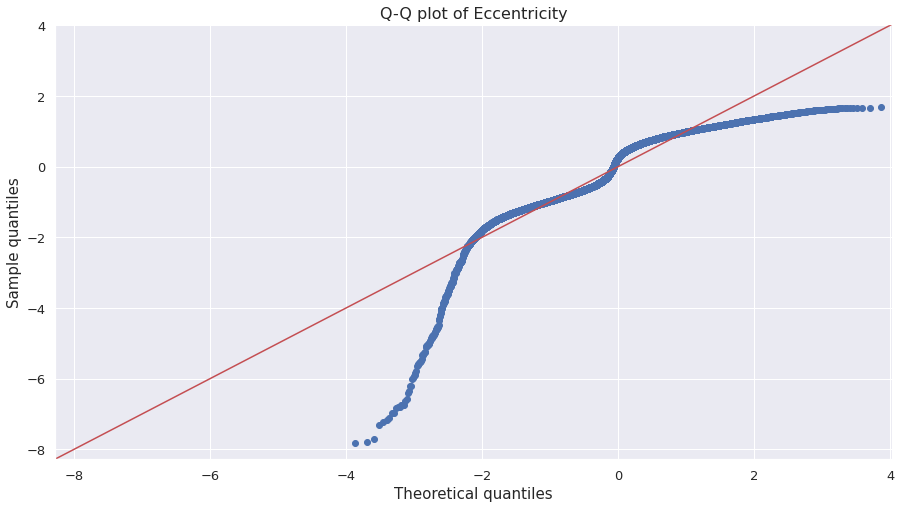

<Figure size 576x360 with 0 Axes>

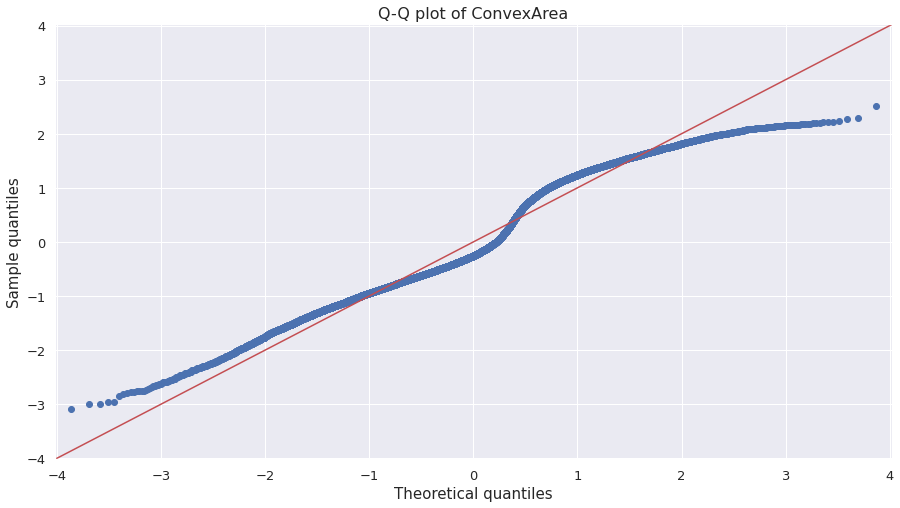

<Figure size 576x360 with 0 Axes>

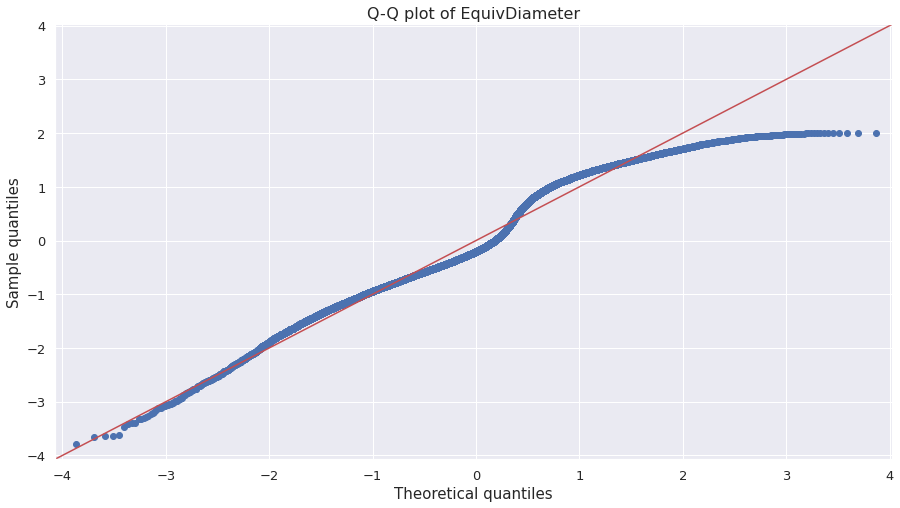

<Figure size 576x360 with 0 Axes>

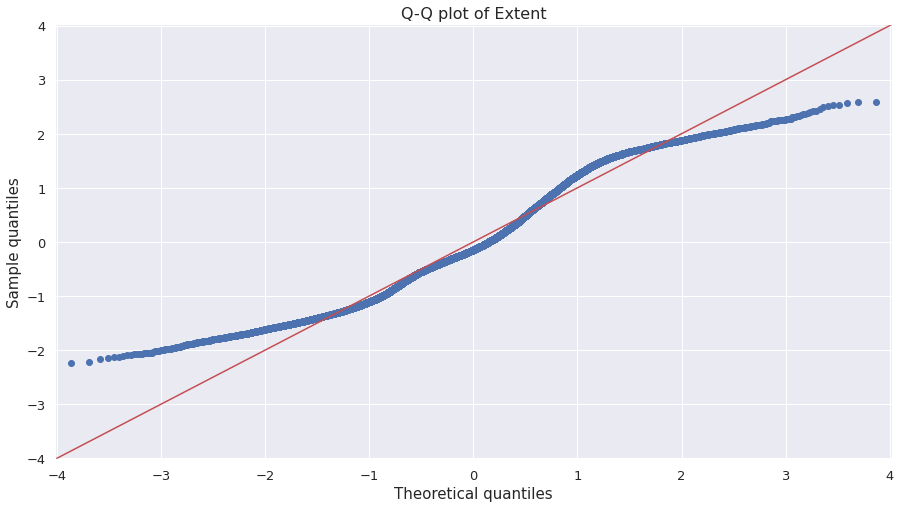

<Figure size 576x360 with 0 Axes>

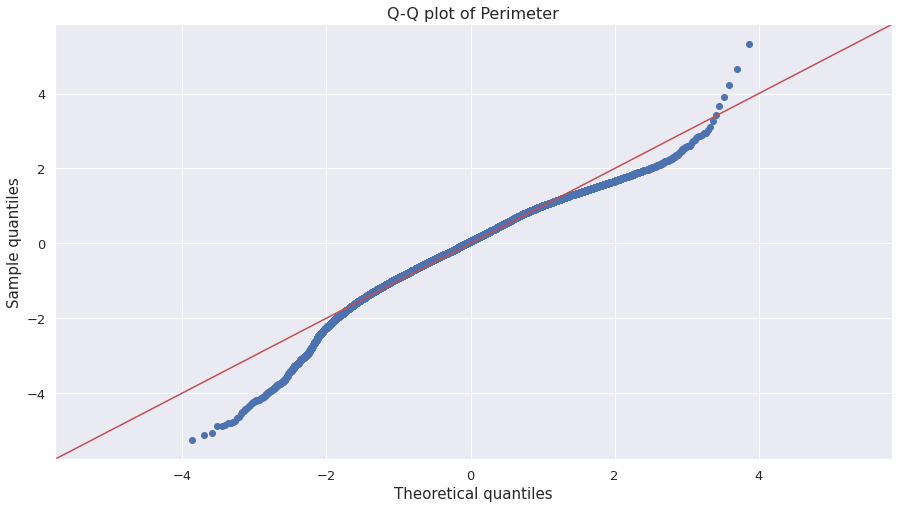

<Figure size 576x360 with 0 Axes>

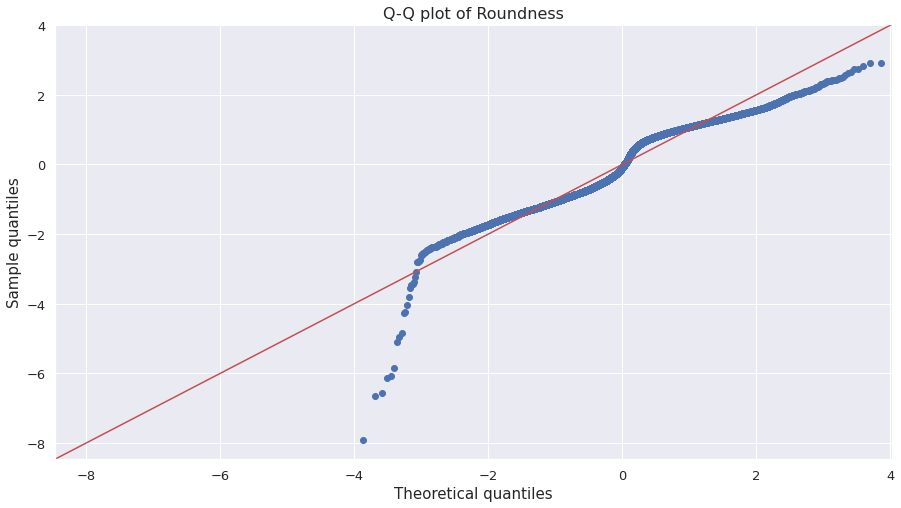

<Figure size 576x360 with 0 Axes>

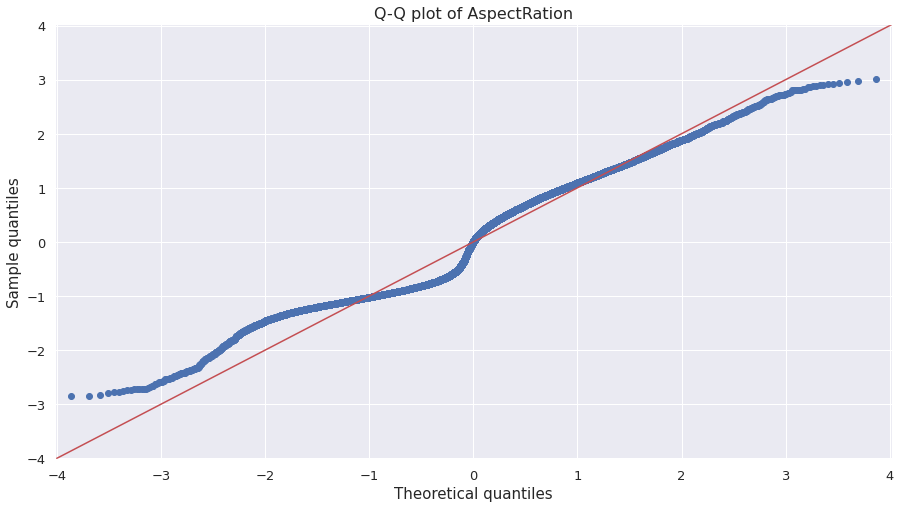

In [ ]:
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
data_norm= X_s
for c in data_norm.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_norm[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()



> Except Roundness, Eccentricity, MajorAxisLength others follow a somewhat normal distribution.



Now we will scale the test and train data and fit logistic regression on it.

We have used a Standard Scaler that converts all units to Simple Normal Distribution with mean =0 and SD = 1

In [114]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)



## Logistic Regression Algorithm

In [116]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics
lr_model = lr()
lr_model.fit(X_train_scaled,y_train)
y_predicted = lr_model.predict(X_test_scaled)
print("Accuracy of Logistic Regression Model is = {0: .3f}".format(metrics.accuracy_score(y_test,y_predicted)))

Accuracy of Logistic Regression Model is =  0.986


**Q. Remove outliers and keep outliers (does if have an effect of the final predictive model)?**

>To test this, let us remove the outliers, fit the logistic Regression model and compare the accuracy.



> First we will write a function to calculate the IQR



In [120]:
# Calculating the IQR
def iqr_calculation(main_df,col):
    Q1 = np.percentile(col,25,interpolation = 'midpoint')
    Q3 = np.percentile(col,75,interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper = np.where(col>=(Q3+1.5*IQR))
    lower = np.where(col<=(Q1-1.5*IQR))
    return upper,lower



> Remove the outliers and reset the Dataframe Index



In [121]:
# Remove the outliers
def remove_outliers(main_df,upper,lower):
    main_df.drop(upper[0], inplace = True)
    main_df.drop(lower[0], inplace = True)
    print("New Shape: ", main_df.shape)
    return main_df

# Resetting the dataframe index
def reset_dataframe(main_df):
    main_df.reset_index(inplace=True)
    main_df.drop(columns=['index'],inplace=True)
    return main_df

In [128]:
main_df = df

for i in range(0,len(main_df.columns)-1):
    print('For ',df.columns[i])
    upper, lower = iqr_calculation(main_df,df[df.columns[i]])
    main_df = remove_outliers(main_df,upper,lower)
    final_df = reset_dataframe(main_df)

For  Area
New Shape:  (17597, 11)
For  MajorAxisLength
New Shape:  (17513, 11)
For  MinorAxisLength
New Shape:  (17513, 11)
For  Eccentricity
New Shape:  (17513, 11)
For  ConvexArea
New Shape:  (17513, 11)
For  EquivDiameter
New Shape:  (17513, 11)
For  Extent
New Shape:  (17513, 11)
For  Perimeter
New Shape:  (17512, 11)
For  Roundness
New Shape:  (17512, 11)
For  AspectRation
New Shape:  (17512, 11)


In [137]:
X_new = main_df.iloc[:,:-1]
y_new = main_df.iloc[:,-1]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=99 )

X_train__new_scaled = sc.fit_transform(X_train_new)
X_test_new_scaled = sc.fit_transform(X_test_new)




> Fitting the model on outlier-less data



In [138]:
lr_model.fit(X_train__new_scaled,y_train_new)
y_predicted_new = lr_model.predict(X_test_new_scaled)
print("Accuracy of Logistic Regression Model is = {0: .3f}".format(metrics.accuracy_score(y_test_new,y_predicted_new)))

Accuracy of Logistic Regression Model is =  0.991




> Thus, we can say that the accuracy has improved after removing the outliers.



**Q. Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?  That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error.**

> Create 3 col. for numbers for 1%, 5% and 10% missing data - Column selected - MinorAxisLength

In [139]:
df_MinorAxisLength = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_1_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_5_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_10_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['Index'] = range(1, len(df_MinorAxisLength) + 1)
# df_MinorAxisLength['sample_num'] = df['sample_num']/1000
df_MinorAxisLength

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,MinorAxisLength,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent,Index
0,63.762307,63.762307,63.762307,63.762307,1
1,65.738475,65.738475,65.738475,65.738475,2
2,59.843292,59.843292,59.843292,59.843292,3
3,60.416315,60.416315,60.416315,60.416315,4
4,60.178119,60.178119,60.178119,60.178119,5
...,...,...,...,...,...
17507,51.029281,51.029281,51.029281,51.029281,17508
17508,58.141659,58.141659,58.141659,58.141659,17509
17509,52.908085,52.908085,52.908085,52.908085,17510
17510,51.474600,51.474600,51.474600,51.474600,17511



##Below function checks the % of missing values




In [140]:
def get_percent_missing(dataframe):
    
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [141]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                              0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  
Index                                        0.0  


##Below function creates missing values

In [142]:
def create_missing(dataframe, percent, col):
    dataframe.loc[dataframe.sample(frac = percent).index, col] = np.nan

In [143]:
create_missing(df_MinorAxisLength, 0.01, 'MinorAxisLength_copy_1_percent')
create_missing(df_MinorAxisLength, 0.05, 'MinorAxisLength_copy_5_percent')
create_missing(df_MinorAxisLength, 0.1, 'MinorAxisLength_copy_10_percent')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [144]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                         0.000000  
MinorAxisLength_copy_1_percent          0.999315  
MinorAxisLength_copy_5_percent          5.002284  
MinorAxisLength_copy_10_percent         9.998858  
Index                                   0.000000  


In [145]:
# Store Index of NaN values in each coloumns
MinorAxisLength_1_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_1_percent'].isna())[0])
MinorAxisLength_5_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_5_percent'].isna())[0])
MinorAxisLength_10_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_10_percent'].isna())[0])

In [146]:
print(f"Length of number_1_idx is {len(MinorAxisLength_1_idx)} and it contains {(len(MinorAxisLength_1_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_1_percent']))*100} % of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_1_percent'])}")
print(f"Length of number_5_idx is {len(MinorAxisLength_5_idx)} and it contains {(len(MinorAxisLength_5_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_5_percent']))*100} % of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_5_percent'])}")
print(f"Length of number_10_idx is {len(MinorAxisLength_10_idx)} and it contains {(len(MinorAxisLength_10_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_10_percent']))*100} % of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_10_percent'])}")

Length of number_1_idx is 175 and it contains 0.9993147555961627 % of total data in column | Total rows: 17512
Length of number_5_idx is 876 and it contains 5.002284148012792 % of total data in column | Total rows: 17512
Length of number_10_idx is 1751 and it contains 9.998857925993605 % of total data in column | Total rows: 17512


### Perform KNN impute to df_number dataframe



>  KNN imputer uses the K-nearest neighbour algorithm to impute missing values. It analyses k similar points and uses their average as the value to impute.

More about this [here](https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e)



In [162]:
#Creating a seperate dataframe for performing the KNN imputation
from sklearn.impute import KNNImputer
df_MinorAxisLength_v2 = df_MinorAxisLength[['Index','MinorAxisLength_copy_1_percent','MinorAxisLength_copy_5_percent','MinorAxisLength_copy_10_percent']]
imputer = KNNImputer(n_neighbors=5)
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_MinorAxisLength_v2), columns = df_MinorAxisLength_v2.columns)

In [163]:
imputed_number_df.sample(10)

,Index,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent
7554,7555.0,47.925489,47.925489,47.925489
2670,2671.0,56.063995,56.063995,56.063995
1099,1100.0,55.899278,55.899278,55.899278
13104,13105.0,71.718609,71.718609,71.718609
14568,14569.0,68.522723,68.522723,68.522723
4226,4227.0,53.685486,53.685486,53.685486
5889,5890.0,53.610174,53.610174,53.610174
8321,8322.0,52.177139,52.177139,52.177139
17158,17159.0,68.115156,68.115156,68.298976
8775,8776.0,39.872105,39.872105,39.872105


In [164]:
#Check the % missing data in dataframe now
print(get_percent_missing(imputed_number_df))

                                                     column_name  \
Index                                                      Index   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   

                                 percent_missing  
Index                                        0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  


In [165]:
imputed_number_df['original_MinorAxisLength'] = df_MinorAxisLength['MinorAxisLength']
imputed_number_df['diff_1_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_1_percent']
imputed_number_df['diff_5_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_5_percent']
imputed_number_df['diff_10_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_10_percent']


In [153]:
for i in MinorAxisLength_10_idx:
    print(str(imputed_number_df['MinorAxisLength_copy_10_percent'][i])+", "+str(imputed_number_df['original_MinorAxisLength'][i])+", "+str(imputed_number_df['diff'][i]))

58.095364602000004, 56.4069029, -1.688461702000005
58.506813776, 57.05443377, -1.4523800059999985
58.693353179999995, 53.86276766, -4.8305855199999925
57.27632043, 55.91659689, -1.3597235399999974
56.455237868000005, 59.41414409, 2.958906221999996
56.257917564, 62.26812033, 6.010202765999999
53.967337042, 56.88359072, 2.916253678000004
53.65476549, 56.99509238, 3.34032689
56.551215764000005, 60.38906563, 3.837849865999992
55.897670268, 57.29217906, 1.3945087920000034
55.628512091999994, 54.63140182, -0.9971102719999934
54.522058644000005, 55.16306151, 0.6410028659999938
53.76896753799999, 57.36528616, 3.5963186220000054
56.842545366, 60.00703819, 3.164492824
55.013296786, 51.78671405, -3.2265827359999975
54.579471346000005, 53.7414814, -0.8379899460000075
54.717001161999995, 56.52457757, 1.8075764080000027
56.976906532, 56.90849866, -0.06840787200000165
56.673731192000005, 57.95157917, 1.277847977999997
53.33658830999999, 59.48420055, 6.147612240000008
54.367377741999995, 50.78150019, 

> Calculating the Error , Bias and Variance for 1% , 5% and 10% imputated data

In [166]:
imputed_number_df['diff_1_percent'] = imputed_number_df['diff_1_percent'].astype(float)
imputed_number_df['diff_5_percent'] = imputed_number_df['diff_5_percent'].astype(float)
imputed_number_df['diff_10_percent'] = imputed_number_df['diff_10_percent'].astype(float)

print("Error for 1% Imputation =",imputed_number_df['diff_1_percent'].sum(axis=0))
print("Error for 5% Imputation =",imputed_number_df['diff_5_percent'].sum(axis=0))
print("Error for 10% Imputation =",imputed_number_df['diff_10_percent'].sum(axis=0))

Error for 1% Imputation = 14.89091162599987
Error for 5% Imputation = -66.91915911199985
Error for 10% Imputation = -130.4798318980002


In [167]:
from math import sqrt
variance_1_percent = (imputed_number_df['diff_1_percent'] ** 2)/(len(imputed_number_df)-1)
variance_5_percent = (imputed_number_df['diff_5_percent'] ** 2)/(len(imputed_number_df)-1)
variance_10_percent = (imputed_number_df['diff_10_percent'] ** 2)/(len(imputed_number_df)-1)
print("Variance for 1 percent missing data is  ",variance_1_percent.sum(axis=0))
print("Variance for 5 percent missing data is  ",variance_5_percent.sum(axis=0))
print("Variance for 10 percent missing data is  ",variance_10_percent.sum(axis=0))


Variance for 1 percent missing data is   0.04131698554564018
Variance for 5 percent missing data is   0.2564091018752976
Variance for 10 percent missing data is   0.49537493961572365


In [168]:
acutual = imputed_number_df['original_MinorAxisLength'].sum(axis=0) 
predicted_1_percent = imputed_number_df['MinorAxisLength_copy_1_percent'].sum(axis=0) 
predicted_5_percent = imputed_number_df['MinorAxisLength_copy_5_percent'].sum(axis=0) 
predicted_10_percent = imputed_number_df['MinorAxisLength_copy_10_percent'].sum(axis=0) 
N = len(MinorAxisLength_10_idx) - 1

bias_1_percent = (acutual - predicted_1_percent) / N
bias_5_percent = (acutual - predicted_5_percent) / N
bias_10_percent = (acutual - predicted_10_percent) / N
print("Bias for 1 percent missing data is = ",bias_1_percent)
print("Bias for 5 percent missing data is = ",bias_5_percent)
print("Bias for 10 percent missing data is = ",bias_10_percent)

Bias for 1 percent missing data is =  0.008509092357807925
Bias for 5 percent missing data is =  -0.03823951949259
Bias for 10 percent missing data is =  -0.07455990394178245


### Imputation Method - Mean Imputation

> The missing values are imputed by mean of the feature.

In [169]:
from sklearn.impute import SimpleImputer

In [170]:
df_MinorAxisLength = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_1_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_5_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_10_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['Index'] = range(1, len(df_MinorAxisLength) + 1)
# df_MinorAxisLength['sample_num'] = df['sample_num']/1000
df_MinorAxisLength

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,MinorAxisLength,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent,Index
0,63.762307,63.762307,63.762307,63.762307,1
1,65.738475,65.738475,65.738475,65.738475,2
2,59.843292,59.843292,59.843292,59.843292,3
3,60.416315,60.416315,60.416315,60.416315,4
4,60.178119,60.178119,60.178119,60.178119,5
...,...,...,...,...,...
17507,51.029281,51.029281,51.029281,51.029281,17508
17508,58.141659,58.141659,58.141659,58.141659,17509
17509,52.908085,52.908085,52.908085,52.908085,17510
17510,51.474600,51.474600,51.474600,51.474600,17511


In [171]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                              0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  
Index                                        0.0  


In [172]:
create_missing(df_MinorAxisLength, 0.01, 'MinorAxisLength_copy_1_percent')
create_missing(df_MinorAxisLength, 0.05, 'MinorAxisLength_copy_5_percent')
create_missing(df_MinorAxisLength, 0.1, 'MinorAxisLength_copy_10_percent')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [173]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                         0.000000  
MinorAxisLength_copy_1_percent          0.999315  
MinorAxisLength_copy_5_percent          5.002284  
MinorAxisLength_copy_10_percent         9.998858  
Index                                   0.000000  


In [ ]:
# Store Index of NaN values in each coloumns
MinorAxisLength_1_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_1_percent'].isna())[0])
MinorAxisLength_5_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_5_percent'].isna())[0])
MinorAxisLength_10_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_10_percent'].isna())[0])

In [174]:
print(f"Length of number_1_idx is {len(MinorAxisLength_1_idx)} and it contains {(len(MinorAxisLength_1_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_1_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_1_percent'])}")
print(f"Length of number_5_idx is {len(MinorAxisLength_5_idx)} and it contains {(len(MinorAxisLength_5_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_5_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_5_percent'])}")
print(f"Length of number_10_idx is {len(MinorAxisLength_10_idx)} and it contains {(len(MinorAxisLength_10_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_10_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_10_percent'])}")

Length of number_1_idx is 175 and it contains 0.9993147555961627% of total data in column | Total rows: 17512
Length of number_5_idx is 876 and it contains 5.002284148012792% of total data in column | Total rows: 17512
Length of number_10_idx is 1751 and it contains 9.998857925993605% of total data in column | Total rows: 17512


In [175]:
df_MinorAxisLength_v2 = df_MinorAxisLength[['Index','MinorAxisLength_copy_1_percent','MinorAxisLength_copy_5_percent','MinorAxisLength_copy_10_percent']]
imputer = SimpleImputer(strategy='most_frequent')
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_MinorAxisLength_v2), columns = df_MinorAxisLength_v2.columns)

In [176]:
imputed_number_df.sample(10)

,Index,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent
15672,15673.0,69.128335,36.177914,69.128335
4034,4035.0,54.091725,54.091725,54.091725
10531,10532.0,36.177914,74.188986,74.188986
2408,2409.0,48.954240,48.954240,48.954240
4633,4634.0,55.766320,55.766320,55.766320
9116,9117.0,50.813106,50.813106,50.813106
11307,11308.0,67.623659,67.623659,67.623659
10516,10517.0,41.238801,41.238801,36.177914
11655,11656.0,73.253408,73.253408,73.253408
9266,9267.0,46.806614,46.806614,46.806614


In [177]:
print(get_percent_missing(imputed_number_df))

                                                     column_name  \
Index                                                      Index   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   

                                 percent_missing  
Index                                        0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  


In [179]:
imputed_number_df['original_MinorAxisLength'] = df_MinorAxisLength['MinorAxisLength']
imputed_number_df['diff_1_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_1_percent']
imputed_number_df['diff_5_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_5_percent']
imputed_number_df['diff_10_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_10_percent']
print("Difference for 1 percent missing data .. first 3 rows only ",imputed_number_df['diff_1_percent'].head(3).sum(axis=0))
print("Difference for 5 percent missing data .. first 3 rows only ",imputed_number_df['diff_5_percent'].head(3).sum(axis=0))
print("Difference for 10 percent missing data .. first 3 rows only ",imputed_number_df['diff_10_percent'].head(3).sum(axis=0))

Difference for 1 percent missing data .. first 3 rows only  0.0
Difference for 5 percent missing data .. first 3 rows only  0.0
Difference for 10 percent missing data .. first 3 rows only  0.0


In [180]:
for i in MinorAxisLength_10_idx:
    print(str(imputed_number_df['MinorAxisLength_copy_10_percent'][i])+", "+str(imputed_number_df['original_MinorAxisLength'][i])+", "+str(imputed_number_df['diff_10_percent'][i]))

56.4069029, 56.4069029, 0.0
57.05443377, 57.05443377, 0.0
53.86276766, 53.86276766, 0.0
55.91659689, 55.91659689, 0.0
59.41414409, 59.41414409, 0.0
62.26812033, 62.26812033, 0.0
56.88359072, 56.88359072, 0.0
36.1779135, 56.99509238, 20.81717888
60.38906563, 60.38906563, 0.0
36.1779135, 57.29217906, 21.11426556
54.63140182, 54.63140182, 0.0
55.16306151, 55.16306151, 0.0
57.36528616, 57.36528616, 0.0
36.1779135, 60.00703819, 23.82912469
51.78671405, 51.78671405, 0.0
53.7414814, 53.7414814, 0.0
56.52457757, 56.52457757, 0.0
56.90849866, 56.90849866, 0.0
57.95157917, 57.95157917, 0.0
59.48420055, 59.48420055, 0.0
50.78150019, 50.78150019, 0.0
52.65794663, 52.65794663, 0.0
36.1779135, 56.84312868, 20.665215179999997
55.15378802, 55.15378802, 0.0
36.1779135, 52.70560933, 16.52769583
57.92495586, 57.92495586, 0.0
56.65131372, 56.65131372, 0.0
54.02712209, 54.02712209, 0.0
57.73455377, 57.73455377, 0.0
51.4208654, 51.4208654, 0.0
56.77673421, 56.77673421, 0.0
57.46402676, 57.46402676, 0.0
57.1

In [181]:
imputed_number_df['diff_1_percent'] = imputed_number_df['diff_1_percent'].astype(float)
imputed_number_df['diff_5_percent'] = imputed_number_df['diff_5_percent'].astype(float)
imputed_number_df['diff_10_percent'] = imputed_number_df['diff_10_percent'].astype(float)

print("Error for 1% imputation: ",imputed_number_df['diff_1_percent'].sum(axis=0))
print("Error for 5% imputation: ",imputed_number_df['diff_5_percent'].sum(axis=0))
print("Error for 10% imputation: ",imputed_number_df['diff_10_percent'].sum(axis=0))

Error for 1% imputation:  4270.58331328
Error for 5% imputation:  20938.872545299997
Error for 10% imputation:  42121.06829498999


In [182]:
from math import sqrt
variance_1_percent = (imputed_number_df['diff_1_percent'] ** 2)/(len(imputed_number_df)-1)
variance_5_percent = (imputed_number_df['diff_5_percent'] ** 2)/(len(imputed_number_df)-1)
variance_10_percent = (imputed_number_df['diff_10_percent'] ** 2)/(len(imputed_number_df)-1)
print("Variance for 1 percent missing data is  ",variance_1_percent.sum(axis=0))
print("Variance for 5 percent missing data is  ",variance_5_percent.sum(axis=0))
print("Variance for 10 percent missing data is  ",variance_10_percent.sum(axis=0))

Variance for 1 percent missing data is   7.0358441276687165
Variance for 5 percent missing data is   33.5282261819529
Variance for 10 percent missing data is   68.0989554815088


In [183]:
acutual = imputed_number_df['original_MinorAxisLength'].sum(axis=0) 
predicted_1_percent = imputed_number_df['MinorAxisLength_copy_1_percent'].sum(axis=0) 
predicted_5_percent = imputed_number_df['MinorAxisLength_copy_5_percent'].sum(axis=0) 
predicted_10_percent = imputed_number_df['MinorAxisLength_copy_10_percent'].sum(axis=0) 
N = len(MinorAxisLength_10_idx) - 1

SimpleImputer_bias_1_percent = (acutual - predicted_1_percent) / N
SimpleImputer_bias_5_percent = (acutual - predicted_5_percent) / N
SimpleImputer_bias_10_percent = (acutual - predicted_10_percent) / N
print("Bias for 1 percent missing data is = ",SimpleImputer_bias_1_percent)
print("Bias for 5 percent missing data is = ",SimpleImputer_bias_5_percent)
print("Bias for 10 percent missing data is = ",SimpleImputer_bias_10_percent)

Bias for 1 percent missing data is =  2.440333321874296
Bias for 5 percent missing data is =  11.965070025885744
Bias for 10 percent missing data is =  24.069181882851492


### Imputation Method - Iterative Imputer



> Multivariate imputer that estimates each feature from all the others.

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

More on this [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)



In [184]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [185]:
df_MinorAxisLength = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_1_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_5_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['MinorAxisLength_copy_10_percent'] = df[['MinorAxisLength']]
df_MinorAxisLength['Index'] = range(1, len(df_MinorAxisLength) + 1)
# df_MinorAxisLength['sample_num'] = df['sample_num']/1000
df_MinorAxisLength

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,MinorAxisLength,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent,Index
0,63.762307,63.762307,63.762307,63.762307,1
1,65.738475,65.738475,65.738475,65.738475,2
2,59.843292,59.843292,59.843292,59.843292,3
3,60.416315,60.416315,60.416315,60.416315,4
4,60.178119,60.178119,60.178119,60.178119,5
...,...,...,...,...,...
17507,51.029281,51.029281,51.029281,51.029281,17508
17508,58.141659,58.141659,58.141659,58.141659,17509
17509,52.908085,52.908085,52.908085,52.908085,17510
17510,51.474600,51.474600,51.474600,51.474600,17511


In [186]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                              0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  
Index                                        0.0  


In [187]:
create_missing(df_MinorAxisLength, 0.01, 'MinorAxisLength_copy_1_percent')
create_missing(df_MinorAxisLength, 0.05, 'MinorAxisLength_copy_5_percent')
create_missing(df_MinorAxisLength, 0.1, 'MinorAxisLength_copy_10_percent')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [188]:
print(get_percent_missing(df_MinorAxisLength))

                                                     column_name  \
MinorAxisLength                                  MinorAxisLength   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   
Index                                                      Index   

                                 percent_missing  
MinorAxisLength                         0.000000  
MinorAxisLength_copy_1_percent          0.999315  
MinorAxisLength_copy_5_percent          5.002284  
MinorAxisLength_copy_10_percent         9.998858  
Index                                   0.000000  


In [189]:
# Store Index of NaN values in each coloumns
MinorAxisLength_1_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_1_percent'].isna())[0])
MinorAxisLength_5_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_5_percent'].isna())[0])
MinorAxisLength_10_idx = list(np.where(df_MinorAxisLength['MinorAxisLength_copy_10_percent'].isna())[0])

In [190]:
print(f"Length of number_1_idx is {len(MinorAxisLength_1_idx)} and it contains {(len(MinorAxisLength_1_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_1_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_1_percent'])}")
print(f"Length of number_5_idx is {len(MinorAxisLength_5_idx)} and it contains {(len(MinorAxisLength_5_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_5_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_5_percent'])}")
print(f"Length of number_10_idx is {len(MinorAxisLength_10_idx)} and it contains {(len(MinorAxisLength_10_idx)/len(df_MinorAxisLength['MinorAxisLength_copy_10_percent']))*100}% of total data in column | Total rows: {len(df_MinorAxisLength['MinorAxisLength_copy_10_percent'])}")

Length of number_1_idx is 175 and it contains 0.9993147555961627% of total data in column | Total rows: 17512
Length of number_5_idx is 876 and it contains 5.002284148012792% of total data in column | Total rows: 17512
Length of number_10_idx is 1751 and it contains 9.998857925993605% of total data in column | Total rows: 17512


In [191]:
df_MinorAxisLength_v2 = df_MinorAxisLength[['Index','MinorAxisLength_copy_1_percent','MinorAxisLength_copy_5_percent','MinorAxisLength_copy_10_percent']]
imputer = IterativeImputer()
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_MinorAxisLength_v2), columns = df_MinorAxisLength_v2.columns)

In [192]:
imputed_number_df.sample(10)

,Index,MinorAxisLength_copy_1_percent,MinorAxisLength_copy_5_percent,MinorAxisLength_copy_10_percent
13655,13656.0,72.943143,72.943143,72.943156
14556,14557.0,72.427512,72.427512,72.427512
14522,14523.0,70.226750,70.226750,70.226750
716,717.0,52.560806,52.560806,52.560806
7631,7632.0,50.287982,50.287982,50.287982
12975,12976.0,76.877131,76.877131,76.877131
6167,6168.0,54.839632,54.839632,54.839632
304,305.0,55.153788,55.153429,55.153788
3848,3849.0,50.780659,50.780659,50.780659
4141,4142.0,55.191147,55.191147,55.191147


In [194]:
print(get_percent_missing(imputed_number_df))

                                                     column_name  \
Index                                                      Index   
MinorAxisLength_copy_1_percent    MinorAxisLength_copy_1_percent   
MinorAxisLength_copy_5_percent    MinorAxisLength_copy_5_percent   
MinorAxisLength_copy_10_percent  MinorAxisLength_copy_10_percent   

                                 percent_missing  
Index                                        0.0  
MinorAxisLength_copy_1_percent               0.0  
MinorAxisLength_copy_5_percent               0.0  
MinorAxisLength_copy_10_percent              0.0  


In [196]:
imputed_number_df['original_MinorAxisLength'] = df_MinorAxisLength['MinorAxisLength']
imputed_number_df['diff_1_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_1_percent']
imputed_number_df['diff_5_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_5_percent']
imputed_number_df['diff_10_percent'] = imputed_number_df['original_MinorAxisLength'] - imputed_number_df['MinorAxisLength_copy_10_percent']
print("Difference for 1 percent missing data .. first 3 rows only ",imputed_number_df['diff_1_percent'].head(3).sum(axis=0))
print("Difference for 5 percent missing data .. first 3 rows only ",imputed_number_df['diff_5_percent'].head(3).sum(axis=0))
print("Difference for 10 percent missing data .. first 3 rows only ",imputed_number_df['diff_10_percent'].head(3).sum(axis=0))

Difference for 1 percent missing data .. first 3 rows only  0.0
Difference for 5 percent missing data .. first 3 rows only  0.0
Difference for 10 percent missing data .. first 3 rows only  0.0


In [197]:
for i in MinorAxisLength_10_idx:
    print(str(imputed_number_df['MinorAxisLength_copy_10_percent'][i])+", "+str(imputed_number_df['original_MinorAxisLength'][i])+", "+str(imputed_number_df['diff_10_percent'][i]))

57.264364562363944, 57.26437529, 1.0727636052365597e-05
59.314334651680824, 59.31434447, 9.818319178123147e-06
55.63226586112726, 55.63227728, 1.141887273803377e-05
59.4980446866534, 59.49805441, 9.723346600765126e-06
55.960276479708405, 55.96028775, 1.1270291594200899e-05
58.28622349527836, 58.28623371, 1.0214721640977587e-05
61.180612118306804, 61.18062105, 8.931693194824675e-06
59.710328099196, 59.71033765, 9.550804001889901e-06
53.314283053118395, 53.3142954, 1.2346881604230475e-05
54.86534627774791, 54.86535794, 1.1662252092037306e-05
55.446096508420375, 55.44610788, 1.137157962460833e-05
56.46243069507125, 56.46244162, 1.092492875187645e-05
52.73573107254744, 52.73574362, 1.2547452563183015e-05
54.38701855749026, 54.38703038, 1.1822509740966325e-05
51.64836902283448, 51.64838203, 1.3007165520662056e-05
52.473489031701455, 52.47350167, 1.2638298542810844e-05
57.80891747376544, 57.80892777, 1.0296234556506079e-05
58.14616946001065, 58.1461796, 1.0139989356616752e-05
56.666777697060

In [198]:
imputed_number_df['diff_1_percent'] = imputed_number_df['diff_1_percent'].astype(float)
imputed_number_df['diff_5_percent'] = imputed_number_df['diff_5_percent'].astype(float)
imputed_number_df['diff_10_percent'] = imputed_number_df['diff_10_percent'].astype(float)

In [199]:
print('Error for 1% imputed values:',imputed_number_df['diff_1_percent'].sum(axis=0))
print('Error for 5% imputed values:',imputed_number_df['diff_5_percent'].sum(axis=0))
print('Error for 10% imputed values:',imputed_number_df['diff_10_percent'].sum(axis=0))

Error for 1% imputed values: -12.405002287273945
Error for 5% imputed values: -11.560386989377392
Error for 10% imputed values: -12.884412773605462


In [200]:
variance_1_percent = (imputed_number_df['diff_1_percent'] ** 2)/(len(imputed_number_df)-1)
variance_5_percent = (imputed_number_df['diff_5_percent'] ** 2)/(len(imputed_number_df)-1)
variance_10_percent = (imputed_number_df['diff_10_percent'] ** 2)/(len(imputed_number_df)-1)
print("Variance for 1 percent missing data is  ",variance_1_percent.sum(axis=0))
print("Variance for 5 percent missing data is  ",variance_5_percent.sum(axis=0))
print("Variance for 10 percent missing data is  ",variance_10_percent.sum(axis=0))

Variance for 1 percent missing data is   0.014584162053916829
Variance for 5 percent missing data is   0.019508141576458006
Variance for 10 percent missing data is   0.013885910884234343


In [201]:
acutual = imputed_number_df['original_MinorAxisLength'].sum(axis=0) 
predicted_1_percent = imputed_number_df['MinorAxisLength_copy_1_percent'].sum(axis=0) 
predicted_5_percent = imputed_number_df['MinorAxisLength_copy_5_percent'].sum(axis=0) 
predicted_10_percent = imputed_number_df['MinorAxisLength_copy_10_percent'].sum(axis=0) 
N = len(MinorAxisLength_10_idx) - 1

SimpleImputer_bias_1_percent = (acutual - predicted_1_percent) / N
SimpleImputer_bias_5_percent = (acutual - predicted_5_percent) / N
SimpleImputer_bias_10_percent = (acutual - predicted_10_percent) / N
print("Bias for 1 percent missing data is = ",SimpleImputer_bias_1_percent)
print("Bias for 5 percent missing data is = ",SimpleImputer_bias_5_percent)
print("Bias for 10 percent missing data is = ",SimpleImputer_bias_10_percent)

Bias for 1 percent missing data is =  -0.007088572735499059
Bias for 5 percent missing data is =  -0.006605935422437531
Bias for 10 percent missing data is =  -0.0073625215849440016
